<a href="https://colab.research.google.com/github/wal-03/Intern---Sentiment-Categorizer-PK/blob/main/Kategori_Data_Asli_(Ensemble_Model)_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [44]:
pip install emoji

In [45]:
import requests
import re
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Import TF-IDF
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import emoji
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from google.colab import drive

In [46]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
url = '/content/drive/MyDrive/My Colab/Intern/comment categorizer/Onclusive_Social__-_Bank_Indonesia_-_Consumer_Protection.csv'
try:
    df = pd.read_csv(url, low_memory=False, encoding='utf8')
    df.drop(columns=['Title'], inplace=True)
except Exception as e:
    print(f"Error loading or processing data: {e}")
    raise
df

,id,Detail,Link,Source,Update date,Publish date,Sentiment,Ranking,Media type,Tags,...,Reach,Interactions,Notes,Author name,Author handle (@username),Author URL,Gender,Age,Bio,City
0,12885363,@NinukSuparmi Layanan Operasional Kantor Caban...,https://twitter.com/bankbsi_id/status/18892003...,twitter.com,11/02/2025 13:31:00,11/02/2025 13:30:42,No sentiment,10,X (Twitter),"Bank Swasta Nasional,BSI,Earned,Uang Elektroni...",...,11320,0.0,NaN,Bank Syariah Indonesia,bankbsi_id,https://twitter.com/bankbsi_id,Male,NaN,Official Twitter of PT Bank Syariah Indonesia ...,Jakarta
1,12885365,@delprmttt_ Layanan Operasional Kantor Cabang ...,https://twitter.com/bankbsi_id/status/18892003...,twitter.com,11/02/2025 13:31:00,11/02/2025 13:30:41,No sentiment,10,X (Twitter),"Bank Swasta Nasional,BSI,Earned,Uang Elektroni...",...,11320,0.0,NaN,Bank Syariah Indonesia,bankbsi_id,https://twitter.com/bankbsi_id,Male,NaN,Official Twitter of PT Bank Syariah Indonesia ...,Jakarta
2,12885367,@widhisaveedra untuk Layanan Operasional Kanto...,https://twitter.com/bankbsi_id/status/18892003...,twitter.com,11/02/2025 13:31:00,11/02/2025 13:30:41,No sentiment,10,X (Twitter),"Bank Swasta Nasional,BSI,Earned,Uang Elektroni...",...,11320,0.0,NaN,Bank Syariah Indonesia,bankbsi_id,https://twitter.com/bankbsi_id,Male,NaN,Official Twitter of PT Bank Syariah Indonesia ...,Jakarta
3,12885377,@NinukSuparmi penipuan yang mengatasnamakan BS...,https://twitter.com/bankbsi_id/status/18892003...,twitter.com,11/02/2025 13:31:00,11/02/2025 13:30:41,No sentiment,10,X (Twitter),"Bank Swasta Nasional,BSI,Earned,Fraud/Penipuan...",...,11320,0.0,NaN,Bank Syariah Indonesia,bankbsi_id,https://twitter.com/bankbsi_id,Male,NaN,Official Twitter of PT Bank Syariah Indonesia ...,Jakarta
4,12885381,@widhisaveedra aman.\nWaspada penipuan yang me...,https://twitter.com/bankbsi_id/status/18892003...,twitter.com,11/02/2025 13:31:00,11/02/2025 13:30:42,No sentiment,10,X (Twitter),"Bank Swasta Nasional,BSI,Earned,Fraud/Penipuan...",...,11320,0.0,NaN,Bank Syariah Indonesia,bankbsi_id,https://twitter.com/bankbsi_id,Male,NaN,Official Twitter of PT Bank Syariah Indonesia ...,Jakarta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50095,12495703,@kontakBRI min tolong cek dm,https://twitter.com/gorofaiz/status/1885476329...,twitter.com,01/02/2025 17:49:11,01/02/2025 06:52:42,Neutral,3,X (Twitter),"Bank BRI,Bank BUMN,Earned,App Error,Kendala Op...",...,8,0.0,NaN,Anggoro,gorofaiz,https://twitter.com/gorofaiz,Male,NaN,Professional | Investor | Learner,NaN
50096,12508299,[JOGJA]\n•\nBagikan info lowongan ini ke kelua...,https://www.instagram.com/p/DFgkjNpTud5,instagram.com,01/02/2025 23:18:42,01/02/2025 06:46:45,Neutral,8,Instagram,"Earned,Fraud/Penipuan,App Error,Scam,Kendala O...",...,3382,1.0,NaN,dagelan.peye,dagelanpeye,https://www.instagram.com/dagelanpeye,NaN,NaN,NaN,NaN
50097,12514475,Alabama basketball met Georgia in Coleman Coli...,https://eu.tidesports.com/story/sports/college...,eu.tidesports.com,02/02/2025 07:09:10,01/02/2025 07:08:47,Neutral,1,News,"Earned,App Error,News,Kendala Operasional - Bank",...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50098,12541933,Teruntuk kamu si #PejuangKerja!\n\n Cara melam...,https://www.instagram.com/p/DFeh-l5zQak,instagram.com,02/02/2025 20:43:00,01/02/2025 07:00:30,Negative,10,Instagram,"Earned,QRIS,Instagram,Fraud/Penipuan,Scam,Frau...",...,16335,35.0,NaN,LOKER BOGOR,lokerbogor.ig,https://www.instagram.com/lokerbogor.ig,NaN,NaN,"BERBAGI INFORMASI LOWONGAN PEKERJAAN\n CPNS, ...",NaN


In [48]:
# Memisahkan dataframe
df1 = df[['id', 'Detail']]

kolom_df2 = ['id']  # Kolom 'id' selalu dimasukkan
kolom_lain = [kol for kol in df.columns if kol not in ['id', 'Detail']] # Semua kolom selain 'Detail' dan 'id'

if len(kolom_lain) > 0: # kondisi jika kolom lain ada
    df2 = df[kolom_df2 + kolom_lain] # Memasukkan kolom lain jika ada
else:
    df2 = df[kolom_df2] # Hanya kolom 'id' jika tidak ada kolom lain

In [49]:
df1

,id,Detail
0,12885363,@NinukSuparmi Layanan Operasional Kantor Caban...
1,12885365,@delprmttt_ Layanan Operasional Kantor Cabang ...
2,12885367,@widhisaveedra untuk Layanan Operasional Kanto...
3,12885377,@NinukSuparmi penipuan yang mengatasnamakan BS...
4,12885381,@widhisaveedra aman.\nWaspada penipuan yang me...
...,...,...
50095,12495703,@kontakBRI min tolong cek dm
50096,12508299,[JOGJA]\n•\nBagikan info lowongan ini ke kelua...
50097,12514475,Alabama basketball met Georgia in Coleman Coli...
50098,12541933,Teruntuk kamu si #PejuangKerja!\n\n Cara melam...


In [50]:
df2

,id,Link,Source,Update date,Publish date,Sentiment,Ranking,Media type,Tags,Country,...,Reach,Interactions,Notes,Author name,Author handle (@username),Author URL,Gender,Age,Bio,City
0,12885363,https://twitter.com/bankbsi_id/status/18892003...,twitter.com,11/02/2025 13:31:00,11/02/2025 13:30:42,No sentiment,10,X (Twitter),"Bank Swasta Nasional,BSI,Earned,Uang Elektroni...",Indonesia,...,11320,0.0,NaN,Bank Syariah Indonesia,bankbsi_id,https://twitter.com/bankbsi_id,Male,NaN,Official Twitter of PT Bank Syariah Indonesia ...,Jakarta
1,12885365,https://twitter.com/bankbsi_id/status/18892003...,twitter.com,11/02/2025 13:31:00,11/02/2025 13:30:41,No sentiment,10,X (Twitter),"Bank Swasta Nasional,BSI,Earned,Uang Elektroni...",Indonesia,...,11320,0.0,NaN,Bank Syariah Indonesia,bankbsi_id,https://twitter.com/bankbsi_id,Male,NaN,Official Twitter of PT Bank Syariah Indonesia ...,Jakarta
2,12885367,https://twitter.com/bankbsi_id/status/18892003...,twitter.com,11/02/2025 13:31:00,11/02/2025 13:30:41,No sentiment,10,X (Twitter),"Bank Swasta Nasional,BSI,Earned,Uang Elektroni...",Indonesia,...,11320,0.0,NaN,Bank Syariah Indonesia,bankbsi_id,https://twitter.com/bankbsi_id,Male,NaN,Official Twitter of PT Bank Syariah Indonesia ...,Jakarta
3,12885377,https://twitter.com/bankbsi_id/status/18892003...,twitter.com,11/02/2025 13:31:00,11/02/2025 13:30:41,No sentiment,10,X (Twitter),"Bank Swasta Nasional,BSI,Earned,Fraud/Penipuan...",Indonesia,...,11320,0.0,NaN,Bank Syariah Indonesia,bankbsi_id,https://twitter.com/bankbsi_id,Male,NaN,Official Twitter of PT Bank Syariah Indonesia ...,Jakarta
4,12885381,https://twitter.com/bankbsi_id/status/18892003...,twitter.com,11/02/2025 13:31:00,11/02/2025 13:30:42,No sentiment,10,X (Twitter),"Bank Swasta Nasional,BSI,Earned,Fraud/Penipuan...",Indonesia,...,11320,0.0,NaN,Bank Syariah Indonesia,bankbsi_id,https://twitter.com/bankbsi_id,Male,NaN,Official Twitter of PT Bank Syariah Indonesia ...,Jakarta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50095,12495703,https://twitter.com/gorofaiz/status/1885476329...,twitter.com,01/02/2025 17:49:11,01/02/2025 06:52:42,Neutral,3,X (Twitter),"Bank BRI,Bank BUMN,Earned,App Error,Kendala Op...",Indonesia,...,8,0.0,NaN,Anggoro,gorofaiz,https://twitter.com/gorofaiz,Male,NaN,Professional | Investor | Learner,NaN
50096,12508299,https://www.instagram.com/p/DFgkjNpTud5,instagram.com,01/02/2025 23:18:42,01/02/2025 06:46:45,Neutral,8,Instagram,"Earned,Fraud/Penipuan,App Error,Scam,Kendala O...",Indonesia,...,3382,1.0,NaN,dagelan.peye,dagelanpeye,https://www.instagram.com/dagelanpeye,NaN,NaN,NaN,NaN
50097,12514475,https://eu.tidesports.com/story/sports/college...,eu.tidesports.com,02/02/2025 07:09:10,01/02/2025 07:08:47,Neutral,1,News,"Earned,App Error,News,Kendala Operasional - Bank",NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50098,12541933,https://www.instagram.com/p/DFeh-l5zQak,instagram.com,02/02/2025 20:43:00,01/02/2025 07:00:30,Negative,10,Instagram,"Earned,QRIS,Instagram,Fraud/Penipuan,Scam,Frau...",Indonesia,...,16335,35.0,NaN,LOKER BOGOR,lokerbogor.ig,https://www.instagram.com/lokerbogor.ig,NaN,NaN,"BERBAGI INFORMASI LOWONGAN PEKERJAAN\n CPNS, ...",NaN


# Cleaning Text

In [51]:
def clean_text(text):
    # Check if the input is a string; if not, convert it
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters, numbers, etc.
    text = emoji.demojize(text, delimiters=(" ", " "))  # Convert emojis to text
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

In [52]:
df1['cleaned_text'] = df1['Detail'].apply(clean_text)
df1

<ipython-input-52-f3262937b785>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cleaned_text'] = df1['Detail'].apply(clean_text)


,id,Detail,cleaned_text
0,12885363,@NinukSuparmi Layanan Operasional Kantor Caban...,layanan operasional kantor cabang bank syariah...
1,12885365,@delprmttt_ Layanan Operasional Kantor Cabang ...,layanan operasional kantor cabang bank syariah...
2,12885367,@widhisaveedra untuk Layanan Operasional Kanto...,untuk layanan operasional kantor cabang bank s...
3,12885377,@NinukSuparmi penipuan yang mengatasnamakan BS...,penipuan yang mengatasnamakan bsi pastikan men...
4,12885381,@widhisaveedra aman.\nWaspada penipuan yang me...,aman waspada penipuan yang mengatasnamakan bsi...
...,...,...,...
50095,12495703,@kontakBRI min tolong cek dm,min tolong cek dm
50096,12508299,[JOGJA]\n•\nBagikan info lowongan ini ke kelua...,jogja bagikan info lowongan ini ke keluargatem...
50097,12514475,Alabama basketball met Georgia in Coleman Coli...,alabama basketball met georgia in coleman coli...
50098,12541933,Teruntuk kamu si #PejuangKerja!\n\n Cara melam...,teruntuk kamu si pejuangkerja cara melamar pek...


# Fetch Keywords

In [53]:
# Function to fetch and process keywords
def fetch_keywords(url):
    response = requests.get(url)
    if response.status_code == 200:
        lines = response.text.strip().split("\n")
        keywords = {}
        current_category = None
        for line in lines:
            line = line.strip()
            if not line:
                continue  # Skip empty lines
            if line.startswith("[") and line.endswith("]"):  # Vertical format
                current_category = line[1:-1].strip().lower()
                keywords[current_category] = []
            elif ":" in line:  # Horizontal format
                current_category, words = line.split(":", 1)
                current_category = current_category.strip().lower()
                keywords[current_category] = [word.strip().lower() for word in words.split(",") if word.strip()]
            elif current_category:  # Vertical format keywords
                keywords[current_category].append(line.strip().lower())
        return keywords
    else:
        raise Exception(f"Failed to fetch keywords. Status code: {response.status_code}")

# Example usage
keywords_url = 'https://raw.githubusercontent.com/wal-03/Intern---Sentiment-Categorizer-PK/refs/heads/main/keywords.txt'
keywords = fetch_keywords(keywords_url)
keywords

{'fraud & scam': ['hilang',
  'gak ada',
  'penipu',
  'awas',
  'bobol',
  'raib',
  'ludes',
  'dicuri',
  'fraud',
  'scam',
  'palsu',
  'bodong',
  'waspada',
  'hati2',
  'hati-hati',
  'phising',
  'skimming',
  'social enginering',
  'soceng',
  'link',
  'trapping',
  'kembalikan'],
 'error/gagal transaksi & sistem': ['gagal',
  'tidak berhasil',
  'decline',
  'gak masuk',
  'tidak masuk',
  'tidak diterima',
  'gak ada',
  'tidak ada',
  'gak diterima',
  'gak bisa',
  'tidak bisa',
  'kepotong',
  'dipotong',
  'potong',
  'kendala',
  'masalah',
  'status berhasil',
  'terpotong'],
 'penanganan pengaduan': ['call center',
  'melaporkan',
  'lapor',
  'pelaporan',
  'aduan',
  'pengaduan',
  'diproses',
  'proses',
  'telfon',
  'telepon',
  'tlpn',
  'email',
  'disuruh',
  'suruh',
  'tunggu',
  'nunggu',
  'berkali2',
  'berhari2',
  'respon',
  'ribet',
  'gimana sih',
  'tolong balas',
  'tolong bales',
  'bales',
  'terima kasih'],
 'perlindungan data': ['data',
  'pe

# Create Funtion to Categorize Comment and Custom Features

In [54]:
# Function to categorize comments
def categorize_comment(comment, keywords):
    comment_lower = comment.lower()
    for category, words in keywords.items():
        if any(re.search(r'\b' + re.escape(word) + r'\b', comment_lower) for word in words):
            return category
    return 'uncategorized'

# Function to create a custom feature vector based on keywords
def create_custom_features(text, keywords):
    features = {}
    text_lower = text.lower()
    for category, words in keywords.items():
        features[category] = sum(1 for word in words if re.search(r'\b' + re.escape(word) + r'\b', text_lower))
    return features

# Apply Category Function to Text

In [55]:
# Assuming df1 is your DataFrame with a 'text' column
df1['category'] = df1['cleaned_text'].apply(lambda x: categorize_comment(x, keywords))
df1

<ipython-input-55-440236db807a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['category'] = df1['cleaned_text'].apply(lambda x: categorize_comment(x, keywords))


,id,Detail,cleaned_text,category
0,12885363,@NinukSuparmi Layanan Operasional Kantor Caban...,layanan operasional kantor cabang bank syariah...,fraud & scam
1,12885365,@delprmttt_ Layanan Operasional Kantor Cabang ...,layanan operasional kantor cabang bank syariah...,fraud & scam
2,12885367,@widhisaveedra untuk Layanan Operasional Kanto...,untuk layanan operasional kantor cabang bank s...,perlindungan data
3,12885377,@NinukSuparmi penipuan yang mengatasnamakan BS...,penipuan yang mengatasnamakan bsi pastikan men...,perlindungan data
4,12885381,@widhisaveedra aman.\nWaspada penipuan yang me...,aman waspada penipuan yang mengatasnamakan bsi...,fraud & scam
...,...,...,...,...
50095,12495703,@kontakBRI min tolong cek dm,min tolong cek dm,kendala operasinal - bank
50096,12508299,[JOGJA]\n•\nBagikan info lowongan ini ke kelua...,jogja bagikan info lowongan ini ke keluargatem...,fraud & scam
50097,12514475,Alabama basketball met Georgia in Coleman Coli...,alabama basketball met georgia in coleman coli...,uncategorized
50098,12541933,Teruntuk kamu si #PejuangKerja!\n\n Cara melam...,teruntuk kamu si pejuangkerja cara melamar pek...,fraud & scam


# Build and Evaluate Machine Learning Model

In [56]:
# Create custom features
X = pd.DataFrame([create_custom_features(text, keywords) for text in df1['cleaned_text']])
y = df1['cleaned_text'].apply(lambda x: categorize_comment(x, keywords))  # Use your existing categorize_comment function

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} Classification Report:\n{report}")
    return model, y_pred

# Example usage
lg_model, y_pred_lr = train_and_evaluate_model(LogisticRegression(), X_train, y_train, X_test, y_test, "Logistic Regression")
rf_model, y_pred_rf = train_and_evaluate_model(RandomForestClassifier(), X_train, y_train, X_test, y_test, "Random Forest")
svm_model, y_pred_svm = train_and_evaluate_model(SVC(), X_train, y_train, X_test, y_test, "SVM")
nb_model, y_pred_nb = train_and_evaluate_model(MultinomialNB(), X_train, y_train, X_test, y_test, "Naive Bayes")

Logistic Regression Accuracy: 0.9998003992015968
Logistic Regression Classification Report:
                                precision    recall  f1-score   support

error/gagal transaksi & sistem       1.00      1.00      1.00      5091
                  fraud & scam       1.00      1.00      1.00       670
     kendala operasinal - bank       1.00      1.00      1.00      2575
  keterbukaan dan transparansi       1.00      1.00      1.00       154
          penanganan pengaduan       1.00      1.00      1.00       847
             perlindungan data       1.00      1.00      1.00       372
                 uncategorized       1.00      1.00      1.00       311

                      accuracy                           1.00     10020
                     macro avg       1.00      1.00      1.00     10020
                  weighted avg       1.00      1.00      1.00     10020

Random Forest Accuracy: 1.0
Random Forest Classification Report:
                                precision    rec

## Predict New Comment with Each Model

In [57]:
# Function to predict the category of a new comment using a specific model
def predict_with_model(new_comment, keywords, model):
    """
    Predicts the category of a new comment using a trained model.

    Parameters:
    - new_comment (str): The new comment to predict.
    - keywords (dict): The dictionary of keywords for feature creation.
    - model: The trained model (e.g., LogisticRegression, RandomForestClassifier, etc.).

    Returns:
    - predicted_category (str): The predicted category.
    """
    # Clean the new comment
    cleaned_comment = clean_text(new_comment)

    # Create custom features for the new comment
    new_features = create_custom_features(cleaned_comment, keywords)

    # Convert the features into a DataFrame (to match the training data format)
    new_features_df = pd.DataFrame([new_features])

    # Predict the category using the model
    predicted_category = model.predict(new_features_df)

    return predicted_category[0]

In [58]:
# Example of predicting multiple new comments
new_comments = [
    "lambat banget transaksinya",
    "udah down seharian",
    "gk bisa app nya nih",
    "ebanking masih"
]

In [59]:
print("Logistic Regression Predictions:")
for new_comment in new_comments:
    predicted_lr = predict_with_model(new_comment, keywords, lg_model)
    print(f"Comment: '{new_comment}' -> Predicted Category: {predicted_lr}")

print("\nRandom Forest Predictions:")
for new_comment in new_comments:
    predicted_rf = predict_with_model(new_comment, keywords, rf_model)
    print(f"Comment: '{new_comment}' -> Predicted Category: {predicted_rf}")

print("\nSVM Predictions:")
for new_comment in new_comments:
    predicted_svm = predict_with_model(new_comment, keywords, svm_model)
    print(f"Comment: '{new_comment}' -> Predicted Category: {predicted_svm}")

print("\nNaive Bayes Predictions:")
for new_comment in new_comments:
    predicted_nb = predict_with_model(new_comment, keywords, nb_model)
    print(f"Comment: '{new_comment}' -> Predicted Category: {predicted_nb}")


Logistic Regression Predictions:
Comment: 'lambat banget transaksinya' -> Predicted Category: kendala operasinal - bank
Comment: 'udah down seharian' -> Predicted Category: kendala operasinal - bank
Comment: 'gk bisa app nya nih' -> Predicted Category: kendala operasinal - bank
Comment: 'ebanking masih' -> Predicted Category: kendala operasinal - bank

Random Forest Predictions:
Comment: 'lambat banget transaksinya' -> Predicted Category: kendala operasinal - bank
Comment: 'udah down seharian' -> Predicted Category: kendala operasinal - bank
Comment: 'gk bisa app nya nih' -> Predicted Category: kendala operasinal - bank
Comment: 'ebanking masih' -> Predicted Category: kendala operasinal - bank

SVM Predictions:
Comment: 'lambat banget transaksinya' -> Predicted Category: kendala operasinal - bank
Comment: 'udah down seharian' -> Predicted Category: kendala operasinal - bank
Comment: 'gk bisa app nya nih' -> Predicted Category: kendala operasinal - bank
Comment: 'ebanking masih' -> Pred

# Filter Category

In [60]:
# Fungsi untuk menampilkan komentar berdasarkan kategori
def filter_by_category(df, category):
    return df[df['category'] == category]

In [61]:
# Contoh: Menampilkan komentar dengan kategori "Positif"
fraudScam_comments = filter_by_category(df1, "fraud & scam")
print("Komentar dengan kategori fraud & scam:")
fraudScam_comments

Komentar dengan kategori fraud & scam:


,id,Detail,cleaned_text,category
0,12885363,@NinukSuparmi Layanan Operasional Kantor Caban...,layanan operasional kantor cabang bank syariah...,fraud & scam
1,12885365,@delprmttt_ Layanan Operasional Kantor Cabang ...,layanan operasional kantor cabang bank syariah...,fraud & scam
4,12885381,@widhisaveedra aman.\nWaspada penipuan yang me...,aman waspada penipuan yang mengatasnamakan bsi...,fraud & scam
8,12885419,@anaseravny Layanan Operasional Kantor Cabang ...,layanan operasional kantor cabang bank syariah...,fraud & scam
13,12885451,@annisandha Layanan Operasional Kantor Cabang ...,layanan operasional kantor cabang bank syariah...,fraud & scam
...,...,...,...,...
50089,12488399,[JAWA BARAT]\n•\nBagikan info lowongan ini ke ...,jawa barat bagikan info lowongan ini ke keluar...,fraud & scam
50090,12488403,[JAWA BARAT]\n•\nBagikan info lowongan ini ke ...,jawa barat bagikan info lowongan ini ke keluar...,fraud & scam
50091,12495021,INFO LOKER JAKARTA TERBARU! \nBuat kamu yang l...,info loker jakarta terbaru buat kamu yang lagi...,fraud & scam
50096,12508299,[JOGJA]\n•\nBagikan info lowongan ini ke kelua...,jogja bagikan info lowongan ini ke keluargatem...,fraud & scam


In [62]:
errorGagal_comments = filter_by_category(df1, "error/gagal transaksi & sistem")
print("Komentar dengan kategori Error/Gagal Transaksi & Sistem:")
errorGagal_comments

Komentar dengan kategori Error/Gagal Transaksi & Sistem:


,id,Detail,cleaned_text,category
5,12885401,@anaseravny penipuan yang mengatasnamakan BSI....,penipuan yang mengatasnamakan bsi pastikan men...,error/gagal transaksi & sistem
10,12885425,@anaseravny BSI saat ini masih mengalami kenda...,bsi saat ini masih mengalami kendala dan kakak...,error/gagal transaksi & sistem
11,12885427,@anaseravny Assalamualaikum Kak Seraa. Mohon m...,assalamualaikum kak seraa mohon maaf atas kend...,error/gagal transaksi & sistem
12,12885433,@anaseravny Indonesia Call di 14040 atau mengu...,indonesia call di atau mengunjungi kanal resmi...,error/gagal transaksi & sistem
20,12885477,@muchmadfaridm @mandiricare kak mohon info ke ...,kak mohon info ke wa ya agar kendala nya kmu d...,error/gagal transaksi & sistem
...,...,...,...,...
50047,12475317,@yujebing @bankbsi_id Untuk cek kendala kamu s...,untuk cek kendala kamu silakan konfirmasi mela...,error/gagal transaksi & sistem
50049,12475347,@HaloBCA Baik lah kalo begitu saya coba trimak...,baik lah kalo begitu saya coba trimakasih repl...,error/gagal transaksi & sistem
50052,12475395,@sungh00niey @yun_uz @tinkerbellllyy @kontakBR...,iss samaa dari semalem udh telpon cs bri ehh d...,error/gagal transaksi & sistem
50054,12475413,@chocozoraa @bankbsi_id Untuk cek kendala kamu...,untuk cek kendala kamu silakan konfirmasi mela...,error/gagal transaksi & sistem


In [63]:
penangananPengaduan_comments = filter_by_category(df1, "penanganan pengaduan")
print("Komentar dengan kategori penanganan pengaduan:")
penangananPengaduan_comments

Komentar dengan kategori penanganan pengaduan:


,id,Detail,cleaned_text,category
7,12885411,@widhisaveedra Syariah Indonesia Call di 14040...,syariah indonesia call di atau mengunjungi kan...,penanganan pengaduan
17,12885471,"@ennforeis Hai, Sobat BRI. Pesan telah kami re...",hai sobat bri pesan telah kami respon melalui ...,penanganan pengaduan
19,12885475,@bankbsi_id Error lagi min astagfirullah innal...,error lagi min astagfirullah innalillahi reply...,penanganan pengaduan
22,12885503,@NinukSuparmi Indonesia Call di 14040 atau men...,indonesia call di atau mengunjungi kanal resmi...,penanganan pengaduan
23,12885509,@annisandha Indonesia Call di 14040 atau mengu...,indonesia call di atau mengunjungi kanal resmi...,penanganan pengaduan
...,...,...,...,...
49992,12474633,[update] available... @flip_id @bankmandiri @...,update available and transaction done thank yo...,penanganan pengaduan
49995,12474715,"@bank_indonesia :boom: PESAN SEMESTA,...\n.......",boom pesan semesta hukum semesta kebenaran ata...,penanganan pengaduan
50006,12474851,"@mandiricare Baik, cek DM, min, Terima kasih.\...",baik cek dm min terima kasih reply to hai saha...,penanganan pengaduan
50038,12475217,@heyowyaaa @bankbsi_id Mohon kesediaan bapak/i...,mohon kesediaan bapakibu untuk menghubungi lay...,penanganan pengaduan


In [64]:
perlindunganData_comments = filter_by_category(df1, "perlindungan data")
print("Komentar dengan kategori Perlindungan Data:")
perlindunganData_comments

Komentar dengan kategori Perlindungan Data:


,id,Detail,cleaned_text,category
2,12885367,@widhisaveedra untuk Layanan Operasional Kanto...,untuk layanan operasional kantor cabang bank s...,perlindungan data
3,12885377,@NinukSuparmi penipuan yang mengatasnamakan BS...,penipuan yang mengatasnamakan bsi pastikan men...,perlindungan data
6,12885409,@delprmttt_ penipuan yang mengatasnamakan BSI....,penipuan yang mengatasnamakan bsi pastikan men...,perlindungan data
35,12885615,@Piiaannk penipuan yang mengatasnamakan BSI. P...,penipuan yang mengatasnamakan bsi pastikan men...,perlindungan data
38,12885633,@1310pjm_ penipuan yang mengatasnamakan BSI. P...,penipuan yang mengatasnamakan bsi pastikan men...,perlindungan data
...,...,...,...,...
49774,12480015,Kebocoran data pribadi digital yg tejadi di in...,kebocoran data pribadi digital yg tejadi di in...,perlindungan data
49894,12473639,Redeeming old game codes self So I have origin...,redeeming old game codes self so i have origin...,perlindungan data
49967,12474373,"@jekjuneee @jekjuneee Halo Sahabat @jekjunee, ...",halo sahabat agar kami lakukan pengecekan moho...,perlindungan data
49968,12474379,"@jekjuneee @jekjuneee Halo Sahabat @jekjunee, ...",halo sahabat untuk pesan dm yang dikirimkan te...,perlindungan data


In [65]:
keterbukaanTransaksi_comments = filter_by_category(df1, "keterbukaan dan transparansi")
print("Komentar dengan kategori Keterbukaan dan Transparansi:")
keterbukaanTransaksi_comments

Komentar dengan kategori Keterbukaan dan Transparansi:


,id,Detail,cleaned_text,category
104,12886167,@ilachmn kepercayaanya kepada Bank Syariah Ind...,kepercayaanya kepada bank syariah indonesia se...,keterbukaan dan transparansi
178,12886809,@linakrlna Kami informasikan untuk Layanan Ope...,kami informasikan untuk layanan operasional ka...,keterbukaan dan transparansi
445,12884167,kukira pindah dari BSI mobile ke BYOND jadi ga...,kukira pindah dari bsi mobile ke byond jadi ga...,keterbukaan dan transparansi
448,12884177,@azurablush emang parah\nReply to @azurablush:...,emang parah reply to kukira pindah dari bsi mo...,keterbukaan dan transparansi
618,12881375,solusi byond bsi error https://www.ayobandung....,solusi byond bsi error reply to byond by bank ...,keterbukaan dan transparansi
...,...,...,...,...
50009,12474881,@LeoTetelepta @PlenaFinance @AurusOfficial @Ha...,halo kak dengan senang hati kami akan cek info...,keterbukaan dan transparansi
50064,12476837,BPI CC Application (new) self Hi! Nagsubmit po...,bpi cc application new self hi nagsubmit po ak...,keterbukaan dan transparansi
50073,12478097,"Apple configurator issue ( ios app) self Hi, I...",apple configurator issue ios app self hi i am ...,keterbukaan dan transparansi
50079,12478293,Any issue with BSC transfers from web3p librar...,any issue with bsc transfers from webp library...,keterbukaan dan transparansi


In [66]:
kendalaOperasionalBank_comments = filter_by_category(df1, "kendala operasinal - bank")
print("Komentar dengan kategori Kendala Operasinal - Bank:")
kendalaOperasionalBank_comments

Komentar dengan kategori Kendala Operasinal - Bank:


,id,Detail,cleaned_text,category
9,12885421,@wienld Ada sih yg begituh min\nReply to @wien...,ada sih yg begituh min reply to mbanking byond...,kendala operasinal - bank
14,12885453,"@muchmadfaridm @mandiricare Hai, Sobat MANDIRI...",hai sobat mandiri pesan yang dikirimkan melalu...,kendala operasinal - bank
15,12885455,"@muchmadfaridm @mandiricare Hai, Sobat MANDIRI...",hai sobat mandiri mohon maaf atas ketidaknyama...,kendala operasinal - bank
16,12885465,"Hai, Sobat MANDIRI. Mohon maaf atas ketidaknya...",hai sobat mandiri mohon maaf atas ketidaknyama...,kendala operasinal - bank
18,12885473,"@muchmadfaridm @mandiricare Hai, Sobat Mandiri...",hai sobat mandiri pesan yang dikirimkan melalu...,kendala operasinal - bank
...,...,...,...,...
50092,12495509,"@iamjeanne_too Hai, Sobat BRI. Tidak perlu kha...",hai sobat bri tidak perlu khawatir terkait pes...,kendala operasinal - bank
50093,12495513,"@gorofaiz Hai, Sobat BRI. Tidak perlu khawatir...",hai sobat bri tidak perlu khawatir kami sudah ...,kendala operasinal - bank
50094,12495551,"@dracoolha Hai, Sobat BRI. Pesan telah kami re...",hai sobat bri pesan telah kami respons melalui...,kendala operasinal - bank
50095,12495703,@kontakBRI min tolong cek dm,min tolong cek dm,kendala operasinal - bank


In [67]:
# df_kendalaOperasionalBank = kendalaOperasionalBank_comments
# df_kendalaOperasionalBank.to_csv('df_kendalaOperasionalBank.csv', index=False)

In [68]:
uncategorized_comments = filter_by_category(df1, "uncategorized")
print("Komentar dengan kategori uncategorized:")
uncategorized_comments

Komentar dengan kategori uncategorized:


,id,Detail,cleaned_text,category
108,12886183,@aresaaresa28 kepercayaanya kepada Bank Syaria...,kepercayaanya kepada bank syariah indonesia se...,uncategorized
219,12887039,"Solo - \n\nMulai 2021 lalu, Kementerian Agrari...",solo mulai lalu kementerian agraria dan tata r...,uncategorized
300,12882961,JAKARTA - PT Bank Tabungan Negara (Persero) Tb...,jakarta pt bank tabungan negara persero tbk bt...,uncategorized
403,12883803,"@xyabil kak aku juga baru join, boleh dm” ga k...",kak aku juga baru join boleh dm ga kak reply t...,uncategorized
590,12886241,By Andre Yeampierre *\n\nInnovation and Potent...,by andre yeampierre innovation and potential t...,uncategorized
...,...,...,...,...
50001,12474801,Go to Binance Square to answer questions “2” a...,go to binance square to answer questions and h...,uncategorized
50078,12478291,Do NOT reread your essays! self I just went th...,do not reread your essays self i just went thr...,uncategorized
50080,12478299,Self-Introduction! I'm BassCleff self Hey ever...,selfintroduction im basscleff self hey everyon...,uncategorized
50083,12482115,With many industry analysts predicting weak pr...,with many industry analysts predicting weak pr...,uncategorized


# Fine Tuning

## Feature Engineering

In [69]:
# Feature Engineering (TF-IDF)
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
# Change df to df1 to access the 'cleaned_text' column
X_tfidf = tfidf.fit_transform(df1['cleaned_text'])

## Handling Imbalanced Data

In [70]:
# Check class distribution
print("Original class distribution:")
print(y_train.value_counts())

# Calculate the minimum number of samples in any class
min_samples = min(y_train.value_counts())

# Set k_neighbors to be at most one less than the smallest class count
k_neighbors = min(5, min_samples - 1)  # Use 5 as the default, but adjust if necessary

# Initialize SMOTE with the adjusted k_neighbors
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)

# Resample the data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verify resampled data
print("\nResampled class distribution:")
print(pd.Series(y_train_res).value_counts())

Original class distribution:
cleaned_text
error/gagal transaksi & sistem    20435
kendala operasinal - bank         10471
penanganan pengaduan               3203
fraud & scam                       2612
perlindungan data                  1442
uncategorized                      1183
keterbukaan dan transparansi        734
Name: count, dtype: int64

Resampled class distribution:
cleaned_text
keterbukaan dan transparansi      20435
error/gagal transaksi & sistem    20435
kendala operasinal - bank         20435
fraud & scam                      20435
uncategorized                     20435
penanganan pengaduan              20435
perlindungan data                 20435
Name: count, dtype: int64


## Model Evaluation

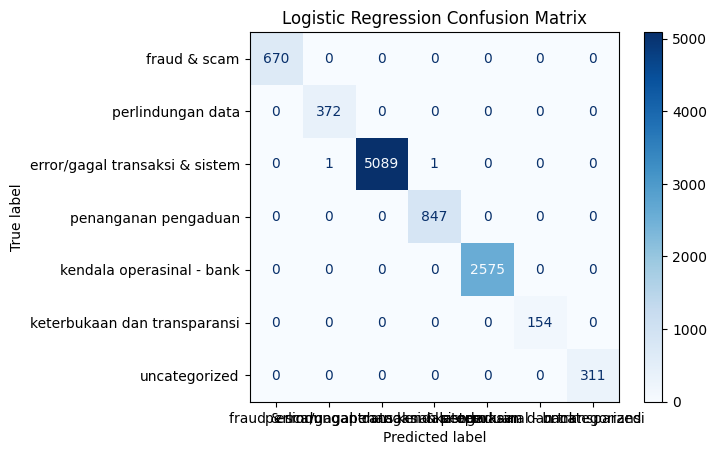

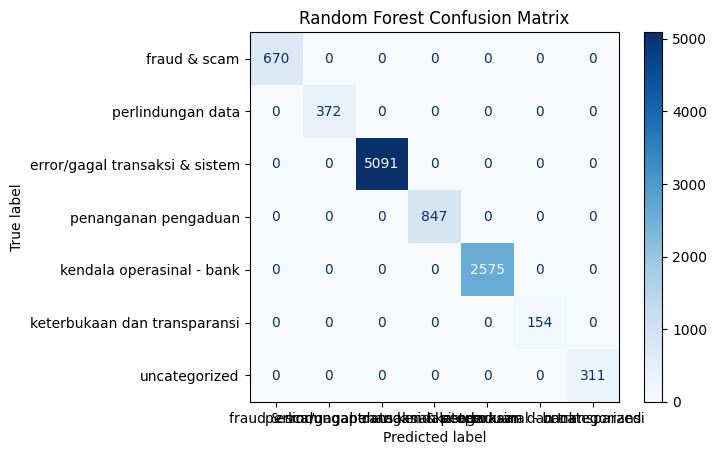

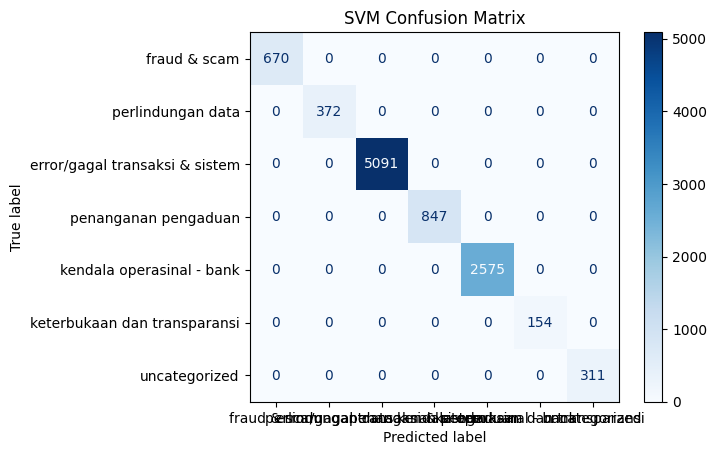

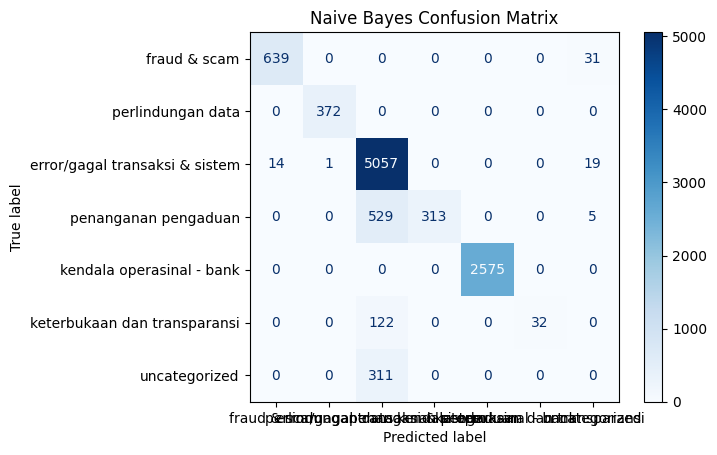

In [71]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Example usage
labels = df1['category'].unique()
plot_confusion_matrix(y_test, y_pred_lr, labels, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf, labels, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_svm, labels, "SVM Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_nb, labels, "Naive Bayes Confusion Matrix")

## Hyperparameter Tuning

In [72]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

Best Parameters: {'C': 10, 'penalty': 'l2'}


## Ensemble Model

In [73]:
# Define your ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression()),  # Logistic Regression
    ('rf', RandomForestClassifier()),  # Random Forest
    ('svm', SVC(probability=True)),  # Support Vector Machine
    ('nb', MultinomialNB())  # Naive Bayes
], voting='soft')  # Use 'soft' voting for probability-based predictions

# Train the ensemble model on your training data
ensemble_model.fit(X_train, y_train)

# Evaluate the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)
print("Accuracy with Ensemble Model:", accuracy_score(y_test, y_pred_ensemble))
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

Accuracy with Ensemble Model: 0.9999001996007985
Classification Report:
                                 precision    recall  f1-score   support

error/gagal transaksi & sistem       1.00      1.00      1.00      5091
                  fraud & scam       1.00      1.00      1.00       670
     kendala operasinal - bank       1.00      1.00      1.00      2575
  keterbukaan dan transparansi       1.00      1.00      1.00       154
          penanganan pengaduan       1.00      1.00      1.00       847
             perlindungan data       1.00      1.00      1.00       372
                 uncategorized       1.00      1.00      1.00       311

                      accuracy                           1.00     10020
                     macro avg       1.00      1.00      1.00     10020
                  weighted avg       1.00      1.00      1.00     10020



### Predict Category with Ensemble Model

In [74]:
# Function to predict the category of a new comment
def predict_comment_category(new_comment, keywords, model):
    # Clean the new comment
    cleaned_comment = clean_text(new_comment)

    # Create custom features for the new comment
    new_features = create_custom_features(cleaned_comment, keywords)

    # Convert the features into a DataFrame (to match the training data format)
    new_features_df = pd.DataFrame([new_features])

    # Predict the category using the ensemble model
    predicted_category = model.predict(new_features_df)

    return predicted_category[0]

In [75]:
def predict_and_append(new_comments_df, df, model, keywords):
    """
    Predicts categories for new comments from a DataFrame and appends them to the existing DataFrame.

    Parameters:
    - new_comments_df (pd.DataFrame): A DataFrame containing new comments. Must have a 'Detail' column.
    - df (pd.DataFrame): The DataFrame to append to. Must have 'Detail' and 'cleaned_text' columns.
    - model: The trained model.
    - keywords (dict): The dictionary of keywords for feature creation.

    Returns:
    - df (pd.DataFrame): The updated DataFrame with new comments and predictions.
    - predictions (list): A list of (comment, category) tuples.
    """
    predictions = []
    for index, row in new_comments_df.iterrows():
        comment = row['Detail']
        predicted_category = predict_comment_category(comment, keywords, model)
        predictions.append((comment, predicted_category))

        # Clean the new comment
        cleaned_comment = clean_text(comment)

        # Create a new row as a dictionary
        new_row = {'Detail': comment, 'category': predicted_category, 'cleaned_text': cleaned_comment}

        # Find the next available 'id'
        if 'id' in df.columns:
            next_id = df['id'].max() + 1 if not df.empty and pd.notna(df['id']).any() else 0
            new_row['id'] = next_id

        # Create a DataFrame from the new row
        new_df = pd.DataFrame([new_row])

        # Concatenate the new DataFrame with the existing DataFrame
        df = pd.concat([df, new_df], ignore_index=True)

    return df, predictions

In [76]:
url = '/content/drive/MyDrive/My Colab/Intern/comment categorizer/df_kendalaOperasionalBank.csv'
try:
    df_new_comment = pd.read_csv(url, low_memory=False, encoding='utf8')
    df_new_comment.drop(columns=['cleaned_text', 'category'], inplace=True)
except Exception as e:
    print(f"Error loading or processing data: {e}")
    raise
df_new_comment

,id,Detail
0,12885421,@wienld Ada sih yg begituh min\nReply to @wien...
1,12885453,"@muchmadfaridm @mandiricare Hai, Sobat MANDIRI..."
2,12885455,"@muchmadfaridm @mandiricare Hai, Sobat MANDIRI..."
3,12885465,"Hai, Sobat MANDIRI. Mohon maaf atas ketidaknya..."
4,12885473,"@muchmadfaridm @mandiricare Hai, Sobat Mandiri..."
...,...,...
13041,12495509,"@iamjeanne_too Hai, Sobat BRI. Tidak perlu kha..."
13042,12495513,"@gorofaiz Hai, Sobat BRI. Tidak perlu khawatir..."
13043,12495551,"@dracoolha Hai, Sobat BRI. Pesan telah kami re..."
13044,12495703,@kontakBRI min tolong cek dm


In [77]:
# Append new comments to the DataFrame
df1, predictions = predict_and_append(df_new_comment, df1, ensemble_model, keywords)

In [78]:
# Assuming 'predictions' is your list of (comment, category) tuples
predictions_df = pd.DataFrame(predictions, columns=['Comment', 'Predicted Category'])
predictions_df

,Comment,Predicted Category
0,@wienld Ada sih yg begituh min\nReply to @wien...,kendala operasinal - bank
1,"@muchmadfaridm @mandiricare Hai, Sobat MANDIRI...",kendala operasinal - bank
2,"@muchmadfaridm @mandiricare Hai, Sobat MANDIRI...",kendala operasinal - bank
3,"Hai, Sobat MANDIRI. Mohon maaf atas ketidaknya...",kendala operasinal - bank
4,"@muchmadfaridm @mandiricare Hai, Sobat Mandiri...",kendala operasinal - bank
...,...,...
13041,"@iamjeanne_too Hai, Sobat BRI. Tidak perlu kha...",kendala operasinal - bank
13042,"@gorofaiz Hai, Sobat BRI. Tidak perlu khawatir...",kendala operasinal - bank
13043,"@dracoolha Hai, Sobat BRI. Pesan telah kami re...",kendala operasinal - bank
13044,@kontakBRI min tolong cek dm,kendala operasinal - bank


In [79]:
# kendalaOperasionalBankCat = predictions_df
# kendalaOperasionalBankCat.to_csv('kendalaOperasionalBankCat.csv', index=False)

In [80]:
# Display the updated DataFrame
print("\nUpdated DataFrame:")
df1


Updated DataFrame:


,id,Detail,cleaned_text,category
0,12885363,@NinukSuparmi Layanan Operasional Kantor Caban...,layanan operasional kantor cabang bank syariah...,fraud & scam
1,12885365,@delprmttt_ Layanan Operasional Kantor Cabang ...,layanan operasional kantor cabang bank syariah...,fraud & scam
2,12885367,@widhisaveedra untuk Layanan Operasional Kanto...,untuk layanan operasional kantor cabang bank s...,perlindungan data
3,12885377,@NinukSuparmi penipuan yang mengatasnamakan BS...,penipuan yang mengatasnamakan bsi pastikan men...,perlindungan data
4,12885381,@widhisaveedra aman.\nWaspada penipuan yang me...,aman waspada penipuan yang mengatasnamakan bsi...,fraud & scam
...,...,...,...,...
63141,12900787,"@iamjeanne_too Hai, Sobat BRI. Tidak perlu kha...",hai sobat bri tidak perlu khawatir terkait pes...,kendala operasinal - bank
63142,12900788,"@gorofaiz Hai, Sobat BRI. Tidak perlu khawatir...",hai sobat bri tidak perlu khawatir kami sudah ...,kendala operasinal - bank
63143,12900789,"@dracoolha Hai, Sobat BRI. Pesan telah kami re...",hai sobat bri pesan telah kami respons melalui...,kendala operasinal - bank
63144,12900790,@kontakBRI min tolong cek dm,min tolong cek dm,kendala operasinal - bank


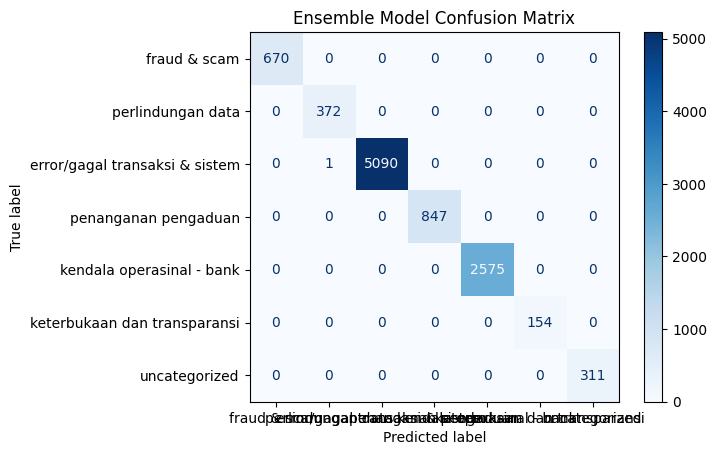

In [81]:
# Plot confusion matrix for the ensemble model
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_ensemble, labels=df1['category'].unique(), title="Ensemble Model Confusion Matrix")

In [82]:
# df1.drop(columns=['cleaned_text'], inplace=True)
# kendalaOperasionalBank_comments = filter_by_category(df1, "kendala operasinal - bank")
# print("Komentar dengan kategori Kendala Operasinal - Bank:")
# kendalaOperasionalBank_comments
# df1

In [83]:
# df_combined = pd.merge(df1, df2, on='id', how='outer')
# df_combined